# PN2V Training
Here we will use the estimated noise model (from ```1a_CreateNoiseModel_GMM``` or ```1b_CreateNoiseModel_Histogram```) and train a PN2V network on single noisy images.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  Download the data from  https://owncloud.mpi-cbg.de/index.php/s/lt3yecHQMKJnJlB/download. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```.  and created a noise model (either GMM based or histogram based, using either the notebook ```1a_CreateNoiseModel_GMM.ipynb``` or ```1b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Mouse actin, the data to be denoised is named ```sample_attempt2.tif``` and not the diaphragm data. For your dataset, ensure that you load the right data. 

In [3]:
path='../../../data/Mouse actin/'
# Load the training data
data=imread(path+'sample_attempt2.tif')
typeNoiseModel='GMM' # Specify either 'GMM' or 'histogram'

In [4]:
if (typeNoiseModel == 'GMM'):
    n_gaussian = 3 # If using GMM noise model, specify number of Gaussians created in 1a_CreateNoiseModel_GMM.ipynb
    n_coeff = 2 # If using GMM noise model, specify number of coefficients created in 1a_CreateNoiseModel_GMM.ipynb
dataName = 'mouseactin' # dataname chosen in `1x_CreateNoiseModel_GMM.ipynb`. This is used to load the right noise model.
mode = 'bootstrap' # Either 'bootstrap'(bootstrapping mode) or 'calibration'(using calibration data)

In [5]:
if(typeNoiseModel=='GMM'):
    namePN2VModel=dataName+'_GMM_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode
    params= np.load(path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     torch.Tensor(params['trained_weight']))
else:
    namePN2VModel=dataName+'_histogram_'+mode
    histogram = np.load(path+'noiseModelHistogram_'+ dataName+'_'+mode+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Create the Network and Train it
This can take a while.

In [6]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

../../unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
../../unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 6.177000617980957+-(2SEM)0.2352494909036002      
Epoch 1 finished      
avg. loss: 5.866308808326721+-(2SEM)0.1904755487427512      
Epoch 2 finished      
avg. loss: 5.7929788589477536+-(2SEM)0.19874599925466513      
Epoch 3 finished      
avg. loss: 5.865933418273926+-(2SEM)0.23563120299274823      
Epoch 4 finished      
avg. loss: 5.740044522285461+-(2SEM)0.1653905833959709      
Epoch 5 finished      
avg. loss: 5.718209743499756+-(2SEM)0.20431839875689464      
Epoch 6 finished      
avg. loss: 5.6764524459838865+-(2SEM)0.1847723285511867      
Epoch 7 finished      
avg. loss: 5.719426584243775+-(2SEM)0.2090384258253608      
Epoch 8 finished      
avg. loss: 5.859592890739441+-(2SEM)0.16808392201771602      
Epoch 9 finished      
avg. loss: 5.746015357971191+-(2SEM)0.17418134803299654      
Epoch 10 finished      
avg. loss: 5.645079636573792+-(2SEM)0.17831624817565453      
Epoch 11 finished      
avg. loss: 5.754001617431641+-(2SEM)0.13234

Epoch 92 finished      
avg. loss: 5.622459745407104+-(2SEM)0.17705145351815926      
Epoch 93 finished      
avg. loss: 5.6002309083938595+-(2SEM)0.14097016426270959      
Epoch 94 finished      
avg. loss: 5.64227328300476+-(2SEM)0.1705206991776566      
Epoch 95 finished      
avg. loss: 5.642793297767639+-(2SEM)0.18747166066786322      
Epoch 96 finished      
avg. loss: 5.607787013053894+-(2SEM)0.1430549618507606      
Epoch 97 finished      
avg. loss: 5.725021505355835+-(2SEM)0.14755955246339686      
Epoch    97: reducing learning rate of group 0 to 7.8125e-06.
Epoch 98 finished      
avg. loss: 5.7141518831253055+-(2SEM)0.18144986839270685      
Epoch 99 finished      
avg. loss: 5.663909530639648+-(2SEM)0.12341164053126058      
Epoch 100 finished      
avg. loss: 5.7180310726165775+-(2SEM)0.16405099090621147      
Epoch 101 finished      
avg. loss: 5.718599557876587+-(2SEM)0.16870838999900936      
Epoch 102 finished      
avg. loss: 5.743638396263123+-(2SEM)0.1602996381428

Epoch 181 finished      
avg. loss: 5.6001654148101805+-(2SEM)0.1590147984409264      
Epoch 182 finished      
avg. loss: 5.634067463874817+-(2SEM)0.17191832753192196      
Epoch 183 finished      
avg. loss: 5.7180277585983275+-(2SEM)0.1803748561857912      
Epoch 184 finished      
avg. loss: 5.756091022491455+-(2SEM)0.15422140201750179      
Epoch 185 finished      
avg. loss: 5.606929230690002+-(2SEM)0.15733435516298266      
Epoch 186 finished      
avg. loss: 5.570531153678894+-(2SEM)0.18602322104480581      
Epoch   186: reducing learning rate of group 0 to 3.0518e-08.
Epoch 187 finished      
avg. loss: 5.832834386825562+-(2SEM)0.1555764195120108      
Epoch 188 finished      
avg. loss: 5.588436579704284+-(2SEM)0.17206238241787544      
Epoch 189 finished      
avg. loss: 5.5932499170303345+-(2SEM)0.11422620240089139      
Epoch 190 finished      
avg. loss: 5.723094010353089+-(2SEM)0.16497589495031034      
Epoch 191 finished      
avg. loss: 5.725453734397888+-(2SEM)0.19731

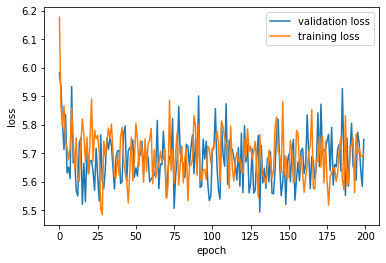

In [7]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()